In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
from snownlp import SnowNLP
from snownlp import sentiment
from snownlp import seg
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import re,math
import pandas as pd

In [2]:
#一整年的凱衛股價、成交量變化資料處理
stock_price=pd.read_csv('../data/5201.csv')
stock_price['data_ym']=stock_price['data_ym'].apply(lambda x: datetime.strftime(datetime.strptime(((str(int(x[0:3])+1911)+x[3:])),'%Y/%m/%d'),'%Y/%m/%d'))
stock_price['amount']=stock_price['amount'].apply(lambda x:int(re.sub(r',','',x)))

#計算凱衛分數
#將留言的分數讀取進來
message=pd.read_csv("../data/5201_push.csv")
message=message[['link','content','tag','author']]

#將文章分數讀取進來
article_score=pd.read_csv('../data/5201_article_by_hand.csv')
article_score=article_score[['link','score','dt']]
article_score.rename(index=str, columns={"dt":"data_ym"},inplace=True)

#噓文需要跟主文章相反
def change_score(tag,word):
    if '噓' in tag:
        if word==1:
            return -1
        if word==-1:
            return 1
    if '→' in tag:
        return 0
    return word

#用留言分數左聯集文章分數，KEY用LINK
message_score=pd.merge(message,article_score,how='left',on='link')
message_score['new']=message_score.apply(lambda x: change_score(x['tag'], x['score']), axis=1)
message_score['data_ym']=message_score['data_ym'].apply(lambda x: datetime.strftime(datetime.strptime(x,'%Y/%m/%d'),'%Y/%m/%d'))
message_score=message_score[['data_ym','new','content']]

#篩選上漲數量、中間數量、下跌數量
down_pop=message_score[message_score['new']==-1]
middle_pop=message_score[message_score['new']==0]
top_pop=message_score[message_score['new']==1]
#檢查原始數量配
print 'down:'+str(len(down_pop))
print 'middle:'+str(len(middle_pop))
print 'top:'+str(len(top_pop))

print len(down_pop)
#將零分轉換成1，-1
def model(x):
    s=SnowNLP(str(x).decode('utf-8'))
    if s.sentiments>=0.51:
        return 1
    if s.sentiments<=0.49:
        return -1
    if s.sentiments==0.5:
        return 0
middle_pop['new']=middle_pop['content'].apply(model)

down:1438
middle:2274
top:1065
1438


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
final_message=pd.concat([top_pop,middle_pop,down_pop])
#篩選上漲數量、中間數量、下跌數量
down_pop=final_message[final_message['new']==-1]
middle_pop=final_message[final_message['new']==0]
top_pop=final_message[final_message['new']==1]

print 'down:'+str(len(down_pop))
print 'middle:'+str(len(middle_pop))
print 'top:'+str(len(top_pop))

message_dm=final_message.groupby(['data_ym','new']).count().unstack(level=-1)
message_dm=message_dm.reset_index()
message=pd.DataFrame({'data_ym':message_dm['data_ym'],
                      'down':message_dm['content'][-1.0],
                      'top':message_dm['content'][1.0],})
message['final']=message['top']-message['down']
message['total']=message['top']+message['down']
final=pd.merge(stock_price,message,how='left',on='data_ym')

#交易策略買進
  #宣告本金
money=100000
tickets=0
buy_money=0
low_limit=0
high_limit=0
x_date=[]
x_price=[]
y_date=[]
y_price=[]

print final.head()

def buy(money,start):
    tickets=0
    tickets=math.floor(money/(start*1000))
    money=money-((start*tickets*1000)*1.006)
    return int(money),int(tickets),start

def sell(money,tickets,start,buy_money):
    money=(tickets*start*1000)+money
    print '獲利金額' + str((start-buy_money)*1000*tickets)
    tickets=0
    buy_money=0
    return tickets,money,buy_money
for index,row in final.iterrows():
    print index,"今天開盤價"+str(row['start']),"現在金額"+str(money),"現在持有張數"+str(tickets),"買進當時股價"+str(buy_money)
    if tickets==0 and row['total']>1 :
        money,tickets,buy_money=buy(money,row['start'])
        print row['data_ym']+"買進",str(tickets)+'張'
        low_limit=buy_money*0.95
        high_limit=buy_money*1.05
        x_date.append(index)
        x_price.append(row['start'])
        continue
    if tickets>0 and (row['start']>high_limit or row['start']<low_limit):
        print row['data_ym']+"賣出",str(tickets)+'張'
        tickets,money,buy_money=sell(money,tickets,row['start'],buy_money)
        y_date.append(index)
        y_price.append(row['start'])

down:3122
middle:46
top:1575
      data_ym  start  amount  down   top  final  total
0  2016/10/03  18.20     550   NaN   NaN    NaN    NaN
1  2016/10/04  21.55    8468   NaN   NaN    NaN    NaN
2  2016/10/05  20.55    1331   NaN   NaN    NaN    NaN
3  2016/10/06  20.80    2517  26.0  25.0   -1.0   51.0
4  2016/10/07  22.40    1945   NaN   NaN    NaN    NaN
0 今天開盤價18.2 現在金額100000 現在持有張數0 買進當時股價0
1 今天開盤價21.55 現在金額100000 現在持有張數0 買進當時股價0
2 今天開盤價20.55 現在金額100000 現在持有張數0 買進當時股價0
3 今天開盤價20.8 現在金額100000 現在持有張數0 買進當時股價0
2016/10/06買進 4張
4 今天開盤價22.4 現在金額16300 現在持有張數4 買進當時股價20.8
2016/10/07賣出 4張
獲利金額6400.0
5 今天開盤價22.5 現在金額105900.0 現在持有張數0 買進當時股價0
6 今天開盤價22.05 現在金額105900.0 現在持有張數0 買進當時股價0
7 今天開盤價24.1 現在金額105900.0 現在持有張數0 買進當時股價0
8 今天開盤價23.45 現在金額105900.0 現在持有張數0 買進當時股價0
9 今天開盤價24.2 現在金額105900.0 現在持有張數0 買進當時股價0
2016/10/17買進 4張
10 今天開盤價24.5 現在金額8519 現在持有張數4 買進當時股價24.2
11 今天開盤價25.45 現在金額8519 現在持有張數4 買進當時股價24.2
2016/10/19賣出 4張
獲利金額5000.0
12 今天開盤價25.15 現在金額110319.0 現在持有張數0 買進當時股價0
13 今天開盤價25.3 現在金額110319

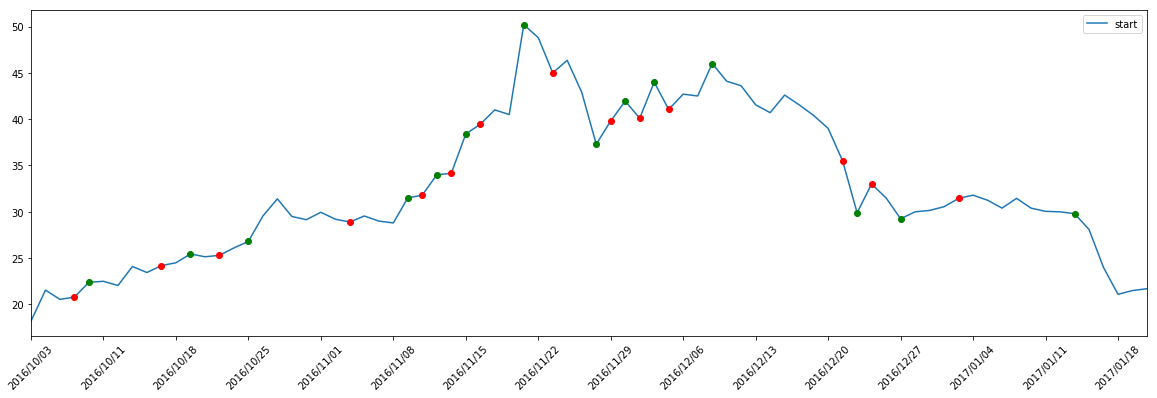

In [6]:
def thin_xticks(ax,ticklabels,tick_gap=5,rotation=45):
    ticks=ax.xaxis.get_ticklocs()
    ax.xaxis.set_ticks(ticks[::tick_gap])
    ax.xaxis.set_ticklabels(ticklabels[::tick_gap],rotation=rotation)
    ax.figure.show()
stock_price['data_ym']=stock_price['data_ym'].apply(lambda x:str(x))
data_ym=stock_price['data_ym'].tolist()
picture=stock_price[['data_ym','start']]
plt=picture.plot(figsize=(20,6))
ticks=np.array(range(len(data_ym)))
plt.set_xticks(ticks)
thin_xticks(plt,data_ym)

plt.plot(x_date,x_price,'ro',c='red')
plt.plot(y_date,y_price,'ro',c='green')

In [7]:
#交易策略買進
  #宣告本金
money=100000
tickets=0
buy_money=0
low_limit=0
high_limit=0
x_date=[]
x_price=[]
y_date=[]
y_price=[]

print final.head()

def buy(money,start):
    tickets=0
    tickets=math.floor(money/(start*1000))
    money=money-((start*tickets*1000)*1.006)
    return int(money),int(tickets),start

def sell(money,tickets,start,buy_money):
    money=(tickets*start*1000)+money
    print '獲利金額' + str((start-buy_money)*1000*tickets)
    tickets=0
    buy_money=0
    return tickets,money,buy_money
for index,row in final.iterrows():
    print index,"今天開盤價"+str(row['start']),"現在金額"+str(money),"現在持有張數"+str(tickets),"買進當時股價"+str(buy_money)
    if tickets==0 and row['total']>1 and row['top']>row['down'] and row['total']>10:
        money,tickets,buy_money=buy(money,row['start'])
        print row['data_ym']+"買進",str(tickets)+'張'
        low_limit=buy_money*0.95
        high_limit=buy_money*1.05
        x_date.append(index)
        x_price.append(row['start'])
        continue
    if tickets>0 and (row['start']>high_limit or row['start']<low_limit or row['top']<row['down']):
        print row['data_ym']+"賣出",str(tickets)+'張'
        tickets,money,buy_money=sell(money,tickets,row['start'],buy_money)
        y_date.append(index)
        y_price.append(row['start'])

      data_ym  start  amount  down   top  final  total
0  2016/10/03  18.20     550   NaN   NaN    NaN    NaN
1  2016/10/04  21.55    8468   NaN   NaN    NaN    NaN
2  2016/10/05  20.55    1331   NaN   NaN    NaN    NaN
3  2016/10/06  20.80    2517  26.0  25.0   -1.0   51.0
4  2016/10/07  22.40    1945   NaN   NaN    NaN    NaN
0 今天開盤價18.2 現在金額100000 現在持有張數0 買進當時股價0
1 今天開盤價21.55 現在金額100000 現在持有張數0 買進當時股價0
2 今天開盤價20.55 現在金額100000 現在持有張數0 買進當時股價0
3 今天開盤價20.8 現在金額100000 現在持有張數0 買進當時股價0
4 今天開盤價22.4 現在金額100000 現在持有張數0 買進當時股價0
5 今天開盤價22.5 現在金額100000 現在持有張數0 買進當時股價0
6 今天開盤價22.05 現在金額100000 現在持有張數0 買進當時股價0
7 今天開盤價24.1 現在金額100000 現在持有張數0 買進當時股價0
8 今天開盤價23.45 現在金額100000 現在持有張數0 買進當時股價0
9 今天開盤價24.2 現在金額100000 現在持有張數0 買進當時股價0
10 今天開盤價24.5 現在金額100000 現在持有張數0 買進當時股價0
11 今天開盤價25.45 現在金額100000 現在持有張數0 買進當時股價0
12 今天開盤價25.15 現在金額100000 現在持有張數0 買進當時股價0
13 今天開盤價25.3 現在金額100000 現在持有張數0 買進當時股價0
14 今天開盤價26.1 現在金額100000 現在持有張數0 買進當時股價0
15 今天開盤價26.8 現在金額100000 現在持有張數0 買進當時股價0
16 今天開盤價29.55 現在金額100000 現在持有張數0 買

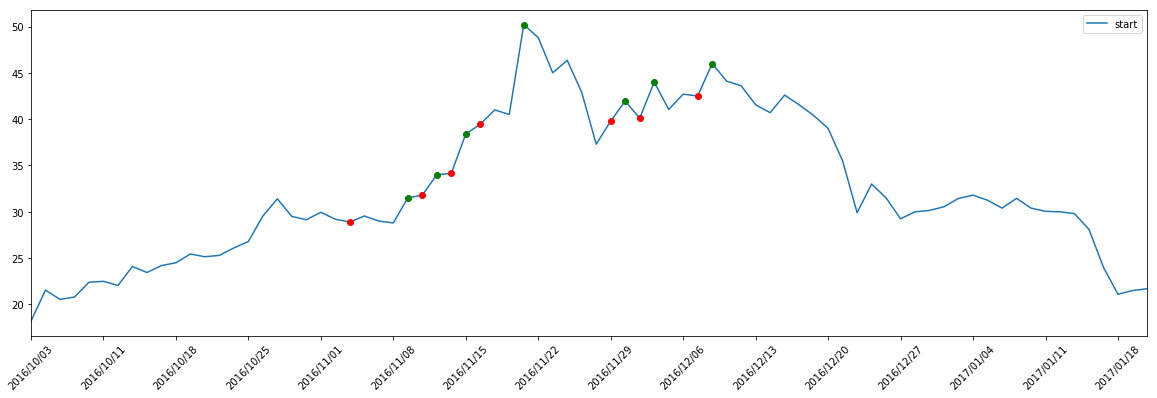

In [8]:
def thin_xticks(ax,ticklabels,tick_gap=5,rotation=45):
    ticks=ax.xaxis.get_ticklocs()
    ax.xaxis.set_ticks(ticks[::tick_gap])
    ax.xaxis.set_ticklabels(ticklabels[::tick_gap],rotation=rotation)
    ax.figure.show()
stock_price['data_ym']=stock_price['data_ym'].apply(lambda x:str(x))
data_ym=stock_price['data_ym'].tolist()
picture=stock_price[['data_ym','start']]
plt=picture.plot(figsize=(20,6))
ticks=np.array(range(len(data_ym)))
plt.set_xticks(ticks)
thin_xticks(plt,data_ym)

plt.plot(x_date,x_price,'ro',c='red')
plt.plot(y_date,y_price,'ro',c='green')